# Introduction #

In this project I download the New York xml file from OpenStreetMaps.org, parse it to get data from nodes and ways, and then clean the street names to ensure they meet the same formats. The only real problem is that it seems some street names are completely wrong and would need to either be deleted or further delved into.

In [25]:
from bs4 import BeautifulSoup                                  #Importing Relevant Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"
import zipfile as zf
import requests, io
import shutil
import html5lib
from plotly.offline import iplot, iplot_mpl 
import plotly.graph_objs as go
%matplotlib inline
import bz2
import xml.etree.cElementTree as et
from collections import defaultdict
import re
import pprint
import csv
import codecs
import cerberus
import sqlite3
from scipy import stats
from IPython.display import display

In [22]:
url="https://s3.amazonaws.com/metro-extracts.mapzen.com/new-york_new-york.osm.bz2"
r=requests.get(url,timeout=1)                                                       #Downloading the dataset to the notebook

In [23]:
def count_tags(filename):
        tags=defaultdict()                                                          #Checking the count of each type of tag
        for event, element in et.iterparse(filename,events=("start",)):
            if element.tag not in tags.keys():
                tags[element.tag]=1
            elif element.tag in tags.keys():
                tags[element.tag]+=1
        return tags

with bz2.BZ2File(io.BytesIO(r.content)) as xml:
    tags=count_tags(xml)

As can bee seen there are 11.5 million nodes, and 1.8 million ways. A lot of this code will obviously take a while to run.

In [26]:
tags

defaultdict(None,
            {'bounds': 1,
             'member': 112118,
             'nd': 14549647,
             'node': 11511646,
             'osm': 1,
             'relation': 9724,
             'tag': 9698321,
             'way': 1804132})

In [28]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')                    #Using Regex to create patterns to recognize potentional
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')            #problems with street names.

def key_type(element, keys):
    if element.tag == "tag":
        if lower.match(element.attrib.get('k')):                        #Adding counts to each of the types in the keys
            keys['lower']+=1                                            #dictionary.
        elif lower_colon.match(element.attrib.get('k')):
            keys['lower_colon']+=1
        elif problemchars.match(element.attrib.get('k')):
            keys['problemchars']+=1
        else:
            keys['other']+=1
        pass
        
    return keys



def process_map_keys(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}     #Returning dictionary with the counts.
    for _, element in et.iterparse(filename):
        keys = key_type(element, keys)

    return keys

with bz2.BZ2File(io.BytesIO(r.content)) as xml:
    keys=process_map_keys(xml)

Most of the problems with the street names is that they seem to be in different formats as seen below

In [29]:
keys

{'lower': 3778075, 'lower_colon': 5789589, 'other': 130657, 'problemchars': 0}

After doing some preliminary investigation. I begin to parse the file for street names that need fixing.

In [34]:
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE) #Regex expression to search for street names at the end of terms.
expected = ["Airport","Alley","Avenue", "Boulevard","Bridge","Building","Circle", \
            "Close","Court","Concourse","Commerce", "Common","Commons","Crescent","Cross","Drive",\
            "Driveway","Expressway","Highway","Lane","Loop","Park","Parkway","Path",\
            "Place","Plaza""Ridge","Road","Route","Run","Slip","Square","Street","Suite",\
            "Terrace","Trace","Trail","Thruway","Turnpike","Walk","Walkway","Way"]
# List of expected names of streets.
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")                      #Function to determine if element has a street name.

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)               #Function to add street names that are not in expected to a list.
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def audit(osm_file):
    street_types = defaultdict(set)                                #Function to parse the xml document
    for event, elem in et.iterparse(osm_file, events=("start",)):  #And use the other functions in conjuction
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    return street_types

with bz2.BZ2File(io.BytesIO(r.content)) as osm_file:
    street_type=audit(osm_file)

In [ ]:
with open('C://Users/Zohaib/Desktop/Lectures/Udacity/Streets.txt','w') as f:     #Print the street types to a file called 
    pprint.pprint(street_type,f)                                                 #Streets.txt to create the mapping dictionary.

After parsing the file for odd street types, a mapping dictionary is created below to fix the street tyes.

In [35]:
mapping = { "Americas\n":"Americas",
            "Ave.":"Avenue",
            "ave":"Avenue",
            "avenue":"Avenue",
            "Ave,":"Avenue",
            "Avene":"Avenue",
            "Aveneu":"Avenue",
            "Ave":"Avenue",
            "AVE.":"Avenue",
            "AVE":"Avenue",
            "AVenue":"Avenue",
            "AVENUE":"Avenue",
            "bl":"Boulevard",
            "bl":"Building",
            "Blv.":"Boulevard",
            "boulevard":"Boulevard",
            "Blvd.":"Boulevard",
            "Blvd":"Boulevard",
            "BLDG":"Building",
            "BLD":"Building",
            "Cir":"Circle",
            "Ct.":"Court",
            "Ct":"Court",
            "Ctr":"Center",
            "Crst":"Cresecent",
            "Cres":"Crescent",
            "Cmn":"Common",
            "Concrs":"Concourse",
            "Cv":"Cove",
            "drive":"Drive",
            "DRIVE":"Drive",
            "Dr.":"Drive",
            "Dr":"Drive",
            "EAST":"East",
            "E":"East",
            "Expy":"Expressway",
            "Grn":"Green",
            "HIGHWAY":"Highway",
            "Hwy":"Highway",
            "LANE":"Lane",
            "lane":"Lane",
            "Ldg":"Landing",
            "Ln":"Lane",
            "N":"North",
            "north":"North",
            "Pky":"Parkway",
            "Pkwy":"Parkway",
            "PLAZA":"Plaza",
            "PARKWAY":"Parkway",
            "Plz":"Plaza",
            "Pl":"Place",
            "Pl":"Place",
            "PLACE":"Place",
            "Pt":"Point",
            "Rd.": "Road",
            "Rd":"Road",
            "ROAD":"Road",
            "Rdg":"Ridge",
            "route":"Route",
            "route":"Route",
            "road":"Road",
            "St.": "Street",
            "St": "Street",
            "st.":"Street",
            "st ":"Street",
            "street":"Street",
            "STREET":"Street",
            "ST":"Street",
            "Ste.":"Suite",
            "Ste":"Suite",
            "STE":"Suite",
            "S":"South",
            "SOUTH":"South",
            "STREET":"Street",
            "Turnlike":"Turnpike",
            "Tunrpike":"Turnpike",
            "Tunpike":"Turnpike",
            "Tpke":"Turnpike",
            "Tirnpike":"Turnpike",
            "Ter":"Terrace",
            "Trce":"Trace",
            "WAY":"Way",
            "W.":"West",
            "W":"West",
            "west":"West",
            "WEST":"West"}                  #Mapping for corrected names.
def update_name(name, mapping):
    map=''
    mapping.keys()
    for i in mapping.keys():                #Function to replace all instances of the occurrences of the odd street type
        name=re.sub('(?<![a-zA-Z0-9])(?<=''){}(?!\.)(?![a-zA-Z0-9\-])'.format(i),mapping[i],name) #in the street names.
    return name                                                     #Uses the re.sub function to replace the street name
                                                                    #with all instances corrected.
for st_type, ways in street_type.items():
        for name in ways:
            better_name = update_name(name, mapping)

Finally, after creating this function, I can now parse the xml document completely and output the relevant lines into csv files.

In [36]:
NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"                               #Name of output files.

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

import sche
SCHEMA = sche.schema                                          #Imports the relevant schema of the relevant elements.

NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']                               #All of the fields wanted for each type of tag.

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements
    list=['id','user','uid','version','lat','lon','timestamp','changeset']
    listw=['id','user','uid','version','timestamp','changeset']
    list1=['id','key','value','type']
    list2=['id','node_id','position']
    if element.tag == 'node':
       node_attribs.update(element.attrib)
       k=node_attribs.keys()
       for i in k:
           if i not in list:
               del node_attribs[i]
       for i in element.iter("tag"):                                   #Takes each element and grabs only the relevant
           temp_dict=defaultdict()                                     #attributes for each type of tag in default dicts/
           if i==None:                                                 #lists.
               continue
           elif ':' in i.attrib.get('k'):
               temp_dict['id']=element.attrib.get('id')
               temp_dict['type']=i.attrib.get('k').partition(':')[0]
               temp_dict['key']=i.attrib.get('k').partition(':')[2]
               temp_dict['value']=i.attrib.get('v')
               tags.append(temp_dict)
           else:
               temp_dict['id']=element.attrib.get('id')
               temp_dict['key']=i.attrib.get('k')
               temp_dict['type']=default_tag_type
               temp_dict['value']=i.attrib.get('v')
               tags.append(temp_dict)
               
            
    elif element.tag == 'way':
        way_attribs.update(element.attrib)
        k=way_attribs.keys()
        for i in k:
            if i not in listw:
                del way_attribs[i]
        for a,i in enumerate(element.iter("nd")):
            temp_dict=defaultdict()
            if i==None:
                continue
            else:
                temp_dict['id']=element.attrib.get('id')
                temp_dict['node_id']=i.attrib.get('ref')
                temp_dict['position']=a
                way_nodes.append(temp_dict)
        for i in element.iter("tag"):
            temp_dict=defaultdict()
            if ':' in i.attrib.get('k'):
                temp_dict['id']=element.attrib.get('id')
                temp_dict['type']=i.attrib.get('k').partition(':')[0]
                temp_dict['key']=i.attrib.get('k').partition(':')[2]
                temp_dict['value']=i.attrib.get('v')
                tags.append(temp_dict)
            else:
                temp_dict['id']=element.attrib.get('id')
                temp_dict['key']=i.attrib.get('k')
                temp_dict['type']=default_tag_type
                temp_dict['value']=i.attrib.get('v')
                tags.append(temp_dict)

    
    if element.tag == 'node':
        return {'node': node_attribs, 'node_tags': tags}
    elif element.tag == 'way':                                  #Returns the relevant lists for the function.
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

In [37]:
def get_element(osm_file, tags=('node', 'way', 'relation')):
    context = et.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:                     #Gets each type of relevant element in the xml file.
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.items())                        #Validates that the elements follow
        message_string = "\nElement of type '{0}' has the following errors:\n{1}" #Schema.
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))

class UnicodeDictWriter(csv.DictWriter, object):
    
    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if type(v)=='str' else v) for k, v in row.items()  #Extends csvwriter to handle
        })                                                                           #Unicode output.
        
    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

In [20]:
def process_map(file_in, validate):

    with codecs.open(NODES_PATH, 'w', encoding='utf-8') as nodes_file,\
        codecs.open(NODE_TAGS_PATH,'w', encoding='utf-8') as nodes_tags_file,\
        codecs.open(WAYS_PATH, 'w', encoding='utf-8') as ways_file,\
        codecs.open(WAY_NODES_PATH, 'w', encoding='utf-8') as way_nodes_file,\
        codecs.open(WAY_TAGS_PATH, 'w', encoding='utf-8') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)  #Iteratively process each XML element
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)     #and write to csv(s)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


with bz2.BZ2File(io.BytesIO(r.content)) as osm_file:
    process_map(osm_file, validate=True)

After this step the file has been iteratively parsed, and the output has been saved to csv files. Thereafter I upload the files to sqlite database called "New_York". Now I access it to run a general query for information.

In [5]:
db=sqlite3.connect("C://Users/Zohaib/Desktop/Lectures/Udacity/sqlite_windows/New_York.db")
cursor=db.cursor()   #Connects to the database with the data from the XML file.

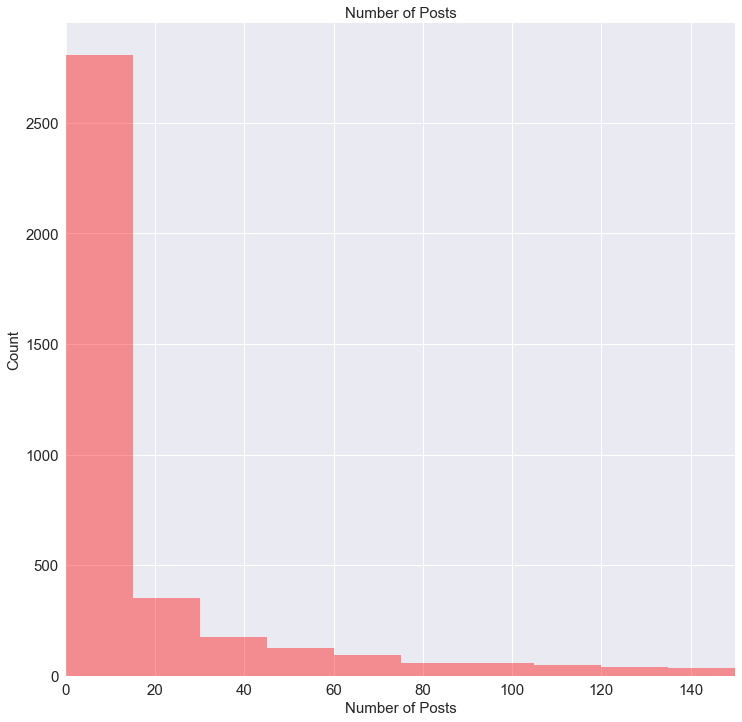

In [43]:
cursor.execute("select user,count(*) from nodes group by user;")
users_sql=cursor.fetchall()
number_of_posts=[x[1] for x in users_sql]                          #Returns count of posts by each user.
posts_reasonable=[]
for i in number_of_posts:
    if i<=150:                                                     #Plots up to the 85th percentile of the results
        posts_reasonable.append(i)                                 #to avoid outliers.
figure=plt.figure(figsize=(12,12))
sns.distplot(posts_reasonable,bins=range(0,151,15),kde=False,color='Red')
plt.xlim(0,150)
plt.title("Number of Posts",fontsize=15)
plt.xlabel("Number of Posts",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

As can be seen above most users post between 1 to about 15 times. Then the number of posts by users decreases steadily. This is to be expected from OpenStreetMaps, as many different users are posting.

# Conclusion #

As can be seen above, there is a lot of information in the New York OSM XML file realeased by OpenStreetMaps.org. There are several formatting issues in just street names. Some of the output also, definitely needs further inquiry though by OpenStreetMaps moderators, for example there are street names in spanish, and some that even include full addresses which does not exactly meet the convention of the rest of the output: "340 Convent Ave, New York, NY 10031, Estados Unidos".

There is a lot more cleaning to be done in this dataset but also a lot that can be gained from analyzing it as well. Just a small smaple can be seen above as user activity can be visualized, and perhaps with further details of users one can determine where most of the information is coming from, and relegate ads to places that have less users contributing